# Franka Panda Robot Control with Simulation

This notebook demonstrates clean robot control using the `RobotExecutor` for both simulation and real robot execution.

**Key Features:**
- Clean separation between simulation and real robot execution
- Target approach (move to grasp pose)  
- Velocity following (manipulation tasks)
- Safe credential handling

In [1]:
# Imports and setup
%load_ext autoreload
%autoreload 2

import os
import time
import getpass
import logging
import numpy as np
import matplotlib.pyplot as plt
import spatialmath as sm
import spatialgeometry as sg

# pandaSim imports
from pandaSim.geometry.rtb_adapter import RoboticsToolboxAdapter
from pandaSim.geometry.utils import create_virtual_panda
from pandaSim.planning.screw_motion_planner import ScrewMotionPlanner
from pandaSim.control import QPController, RobotExecutor, ExecutionConfig

# Real robot imports
import panda_py
from panda_py import controllers, libfranka

logging.basicConfig(level=logging.INFO)

[I 09/24/25 13:30:34.617 21567] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


## Robot Connection Setup

Secure credential loading and robot connection initialization.


In [87]:
# Load credentials safely
try:
    import dotenv
    dotenv.load_dotenv('../.env')  # Load from .env file
except ImportError:
    pass  # python-dotenv not installed, use environment variables

hostname = os.getenv("PANDA_HOST") or input("Panda hostname/IP: ").strip()
username = os.getenv("PANDA_USER") or input("Desk Username: ").strip() 
password = os.getenv("PANDA_PASS") or getpass.getpass("Desk Password: ")

print(f"Connecting to {hostname} as {username}")

# Connect to desk and real robot
desk = panda_py.Desk(hostname, username, password, platform='panda')
unlocked = desk.unlock()

time.sleep(3)


Connecting to 172.16.0.2 as Kao


INFO:desk:Login succesful.
INFO:desk:Retaken control.


In [88]:

panda_real = panda_py.Panda(hostname)
try:
    gripper = libfranka.Gripper(hostname)
    gripper.homing()
    print("Gripper found")
except:
    print("Gripper not found")
    gripper = None

reached = panda_real.move_to_start()

print("Robot reached starting position: ", reached)

INFO:panda:Connected to robot (172.16.0.2).
INFO:panda:Panda class destructor invoked (172.16.0.2).
INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 0.14 seconds.
INFO:panda:Starting new controller (JointTrajectory).


Gripper found
Robot reached starting position:  True


In [85]:
panda_real.move_to_start()
desk.lock()

INFO:panda:Stopping active controller (Integrated Velocity).
INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 3.37 seconds.
INFO:panda:Starting new controller (JointTrajectory).


In [101]:
# Create simulation environment
adapter = RoboticsToolboxAdapter({
    "realtime": True,
    "rate": 100,
    "browser": "google-chrome"  # or "notebook" for visualizing in jupyter notebook
})

# Create virtual robot
urdf_path = '../model/franka_description/robots/frankaEmikaPandaVirtual.urdf'
panda_sim = create_virtual_panda(urdf_path=urdf_path)
panda_sim.base = sm.SE3(0, 0, -0.004)
n = 7  # arm DOF


# Sync simulation with real robot
panda_sim.q[:n] = panda_real.q[:n]

# Add robot to environment
env = adapter.env
env.add(panda_sim)

# Open gripper
if hasattr(panda_sim, 'grippers') and panda_sim.grippers:
    panda_sim.grippers[0].q = [0.035, 0.035]

print(f"Simulation setup complete. Rate: {adapter.env.rate} Hz")

# Create scene objects
box_size = [0.27, 0.065, 0.207]
box_pose = sm.SE3(0.5, -0.2, box_size[2]/2) * sm.SE3.Rz(np.pi/2)
box = sg.Box(
    scale=box_size, 
    color='blue', 
    pose=box_pose
)
robot_desk = sg.Box(
    scale=[0.3, 0.3, 0.004], 
    color='gray', 
    pose=sm.SE3(-0.04, 0, 0.004/2),
)
robot_desk.set_alpha(0.5)
# Visualization axes
ee_axes = sg.Axes(0.15)  # End-effector pose
goal_axes = sg.Axes(0.1)  # Target grasp pose

# Add to environment
env.add(ee_axes)
env.add(goal_axes)
env.add(box)
env.add(robot_desk)
# Update end-effector visualization
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')

# Compute grasp pose
planner = ScrewMotionPlanner(adapter=adapter)

grasp_pose, qs, s_axes = planner.compute_grasp(
    obj=box,
    adapter=adapter,
    grasp_height="top",
    prefer_closer_grasp=False,
    gripper_offset=sm.SE3.Rx(np.pi).A,
    output_type="t"
)

# Update goal visualization
goal_axes.T = grasp_pose

# For object manipulation: compute relative transform
wTg = grasp_pose  # grasp pose in world
wTb = box.T       # box pose in world
gTb = np.linalg.inv(wTg) @ wTb  # box pose in grasp 
adapter.step_simulation(adapter.dt)

print(f"Grasp pose computed. Distance to target: {np.linalg.norm(grasp_pose[:3, 3] - panda_sim.fkine(panda_sim.q).t):.3f}m")


INFO:websockets.server:server listening on 127.0.0.1:53017
INFO:websockets.server:connection open


Simulation setup complete. Rate: 100 Hz
Grasp pose computed. Distance to target: 0.538m


## Controller and Executor Setup

Initialize the QP controller and robot executor with clean configuration.


In [90]:
# Create QP controller
controller = QPController(
    adapter=adapter,
    robot=panda_sim,
    end_effector_link='panda_finger_virtual',
    gains_translation=2.0,
    gains_rotation=1.0,
    threshold=0.005,
    lambda_q=0.05,
    lambda_m=1.0,
    lambda_j=0.1,
    ps=0.05,
    pi=0.3,
    eta=1.0,
    solver="quadprog",
    T=7.0,
)

# Execution configuration (controller-focused parameters only)
config = ExecutionConfig(
    frequency=500.0,
    max_runtime=20.0,
    convergence_threshold=0.005,
    safety_timeout=30.0
)

# Create robot executor
executor = RobotExecutor(controller, adapter, config)

print("Controller and executor ready")


Controller and executor ready


## Case 1: Target Approach - Simulation Only

Move robot to grasp pose using simulation for testing and visualization.


INFO:pandaSim.control.robot_executor:Starting simulation approach to target


Starting simulation approach to grasp pose...


INFO:pandaSim.control.robot_executor:Simulation completed: arrived=True, steps=925



Simulation Results:
  Converged: True
  Steps: 925
  Execution time: 9.24s


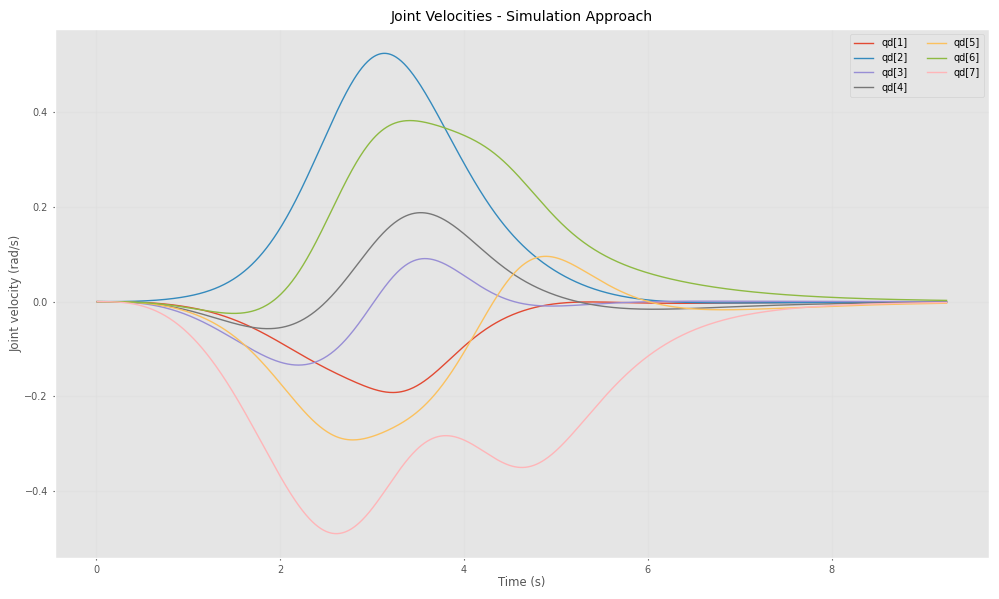

In [67]:
# Execute approach in simulation
print("Starting simulation approach to grasp pose...")

panda_sim.q[:7] = panda_real.q[:7]

# Update visualization
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
adapter.step_simulation(adapter.dt)

result_sim = executor.approach_target(
    target_pose=grasp_pose,
    sim_robot=panda_sim,
    optimization_type="j",  # joint limit optimization
    use_real_robot=False
)
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
adapter.step_simulation(adapter.dt)
q_grasp = panda_sim.q
# Results
print(f"\nSimulation Results:")
print(f"  Converged: {result_sim.converged}")
print(f"  Steps: {result_sim.n_steps}")
print(f"  Execution time: {result_sim.execution_time:.2f}s")




# Plot trajectory
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(min(7, result_sim.joint_velocities.shape[1])):
    ax.plot(result_sim.time_history, result_sim.joint_velocities[:, i], 
            label=f'qd[{i+1}]', linewidth=1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Joint velocity (rad/s)')
ax.set_title('Joint Velocities - Simulation Approach')
ax.legend(ncol=2)
# ax.set_ylim(-3, 3)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# save as pdf
# fig.savefig('approach_simulation.pdf')

# Save simulation data
# result_sim.save("approach_simulation.npz")
# print("Simulation data saved to 'approach_simulation.npz'")


## Case 1: Target Approach - Real Robot

Execute the same approach on the real robot after simulation validation.


In [103]:
robot = panda_real.get_robot()
reading = robot.read_once()

O_T_EE = np.array(reading.O_T_EE).reshape(4, 4).T
panda_sim.q[:n] = reading.q[:n]
ee_axes.T = O_T_EE
adapter.step_simulation(adapter.dt)
print(O_T_EE)

[[ 0.99993447 -0.00861678  0.00612778  0.11116021]
 [-0.00871762 -0.99981418  0.01662436  0.25941689]
 [ 0.00598339 -0.01667669 -0.99984303  0.07228472]
 [ 0.          0.          0.          1.        ]]


In [69]:
# Reset robot to starting position
panda_real.move_to_start()


panda_sim.q[:n] = panda_real.q[:n]
panda_sim.q[-1] = 0.0
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
goal_axes.T = grasp_pose
adapter.step_simulation(adapter.dt)

time.sleep(1)


INFO:panda:Stopping active controller (JointTrajectory).
INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 0.08 seconds.
INFO:panda:Starting new controller (JointTrajectory).


In [70]:
# Update visualization
panda_sim.q[:n] = panda_real.q[:n]
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')

adapter.step_simulation(adapter.dt)

# Execute approach on real robot
print("Starting real robot approach to grasp pose...")
print("⚠️  Real robot will move - ensure workspace is clear!")
if gripper:
    gripper.move(width=0.08, speed=0.05)

result_real = executor.approach_target(
    target_pose=grasp_pose,
    sim_robot=panda_sim,
    real_robot=panda_real,
    optimization_type="j",
    use_real_robot=True  # 🔴 REAL ROBOT EXECUTION
)
# Update visualization
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
adapter.step_simulation(adapter.dt)
# Results
print(f"\nReal Robot Results:")
print(f"  Converged: {result_real.converged}")
print(f"  Steps: {result_real.n_steps}")
print(f"  Execution time: {result_real.execution_time:.2f}s")

# # Save real robot data
# result_real.save("approach_real.npz")
# print("Real robot data saved to 'approach_real.npz'")


Starting real robot approach to grasp pose...
⚠️  Real robot will move - ensure workspace is clear!


INFO:pandaSim.control.robot_executor:Starting real robot approach to target
INFO:panda:Stopping active controller (JointTrajectory).
INFO:panda:Starting new controller (Integrated Velocity).
INFO:panda:Stopping active controller (Integrated Velocity).
INFO:pandaSim.control.robot_executor:Average optimization time per step: 0.001157 seconds
INFO:pandaSim.control.robot_executor:Real robot execution completed: arrived=True



Real Robot Results:
  Converged: True
  Steps: 856
  Execution time: 8.62s


In [26]:
gripper.grasp(width=box_size[1], speed=0.05, force=10)

True

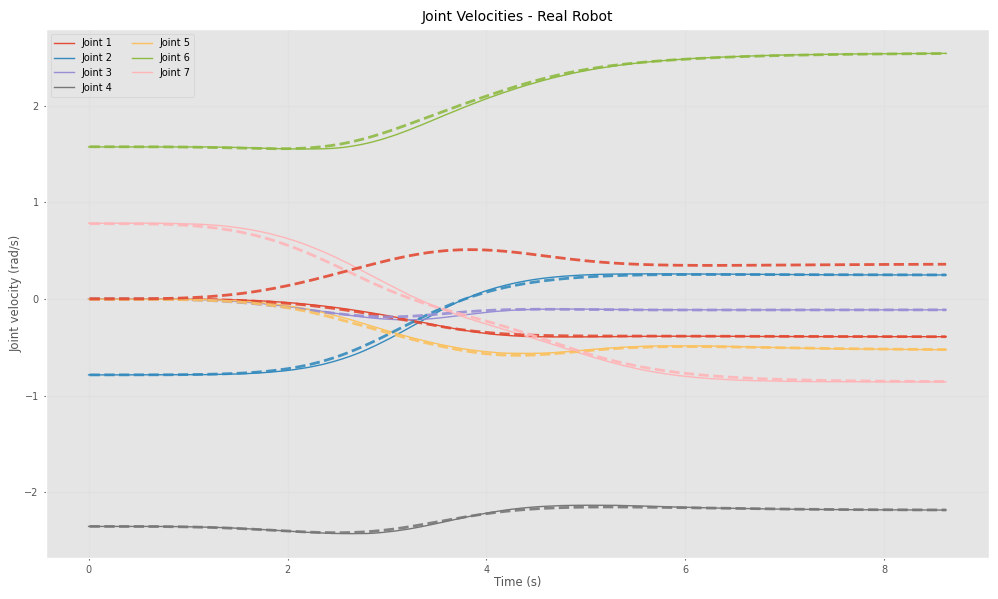

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 37 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'J', 'R', 'T', 'V', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'seven', 'six', 'slash', 'space', 't', 'three', 'two', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 45, 53, 55, 57, 68, 69, 70, 71, 72, 76, 79, 80, 81, 82, 85, 86, 87, 89, 92, 3228]
INFO:fontTools.subset:Closed glyph list over 'MATH': 43 glyphs afte

In [71]:

# Update visualization
# ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
# adapter.step_simulation(adapter.dt)

log = panda_real.get_log()
# Plot trajectory
fig, ax = plt.subplots(figsize=(10, 6))
time_history = (log['time'] - log['time'][0])/1000


# Plot all joints at once and add legend labels
lines = ax.plot(time_history, log['q'], linewidth=1)
# Interpolate desired velocities using scipy (handles 2D arrays)
from scipy.interpolate import interp1d
interp_func = interp1d(result_sim.time_history, result_sim.joint_positions, 
                       axis=0, kind='linear', bounds_error=False)
desired_interp = interp_func(time_history).squeeze()
# Plot desired joint velocities
ax.plot(time_history, desired_interp, '--', linewidth=2, alpha=0.9)



ax.set_xlabel('Time (s)')
ax.set_ylabel('Joint velocity (rad/s)')
ax.set_title('Joint Velocities - Real Robot')
joint_labels = [f'Joint {i+1}' for i in range(7)]
ax.legend(lines, joint_labels, ncol=2)
# ax.set_ylim(-3, 3)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
fig.savefig("joint_velocities_real_robot.pdf", format="pdf", bbox_inches="tight")


## Case 2: Velocity Following - Manipulation Task

Generate twist trajectory for object manipulation and execute velocity commands.


In [79]:
# Update visualization
panda_sim.q[:n] = panda_real.q[:n]
panda_sim.q[-1] = q_grasp[-1]
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
adapter.step_simulation(adapter.dt)

# Generate twist trajectory for manipulation
twist_trajectory = planner.generate_twist_trajectory(
    body_pose=grasp_pose,
    q=qs,
    s_axis=s_axes,
    theta=np.pi/2,  # 90 degree rotation
    h=0.0,          # no translation along screw axis
    Tf=10.0,        # trajectory duration
    time_scaling='quintic',
    body_coordinate=True
)

print(f"Generated twist trajectory with {len(twist_trajectory)} points")

# Execute twist trajectory with real-time velocity computation
print("Starting manipulation in simulation...")

result_manip = executor.follow_twist_trajectory(
    twist_trajectory=twist_trajectory,
    sim_robot=panda_sim,
    optimization_type="j",
    use_real_robot=False
)

print(f"\nManipulation Results:")
print(f"  Steps: {result_manip.n_steps}")
print(f"  Execution time: {result_manip.execution_time:.2f}s")


wTe = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual').A
ee_axes.T = wTe
box.T = wTe @ gTb  # Move box with end-effector (object follows grasp)
adapter.step_simulation(0.01)

# Save manipulation data
result_manip.save("manipulation_simulation.npz")
print("Manipulation data saved to 'manipulation_simulation.npz'")

INFO:pandaSim.control.robot_executor:Starting simulation twist trajectory: 1000 twists


Generated twist trajectory with 1000 points
Starting manipulation in simulation...


INFO:pandaSim.control.robot_executor:Simulation twist trajectory completed



Manipulation Results:
  Steps: 1000
  Execution time: 10.07s
Manipulation data saved to 'manipulation_simulation.npz'


In [83]:
from IPython.display import display, clear_output
# Update visualization
panda_sim.q[:n] = panda_real.q[:n]
panda_sim.q[-1] = q_grasp[-1]
ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
box.T = box_pose
adapter.step_simulation(adapter.dt)


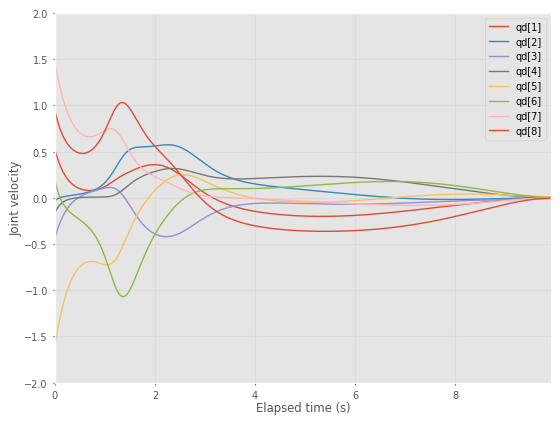

In [84]:

qd_history = []
q_history = []
time_history = []
dt = adapter.dt
elapsed_time = 0.0

fig, ax = plt.subplots()

lines = [ax.plot([], [], label=f'qd[{i+1}]', linewidth=1)[0] for i in range(panda_sim.n)]
ax.set_xlim(0, 20) 
ax.set_ylim(-2, 2)   
ax.set_xlabel('Elapsed time (s)')
ax.set_ylabel('Joint velocity')
ax.legend()
plt.ion()
plt.show()

step = 0
for twist in twist_trajectory:
        # while not arrived:
        qd, arrived = controller.compute_joint_velocities(twist=twist, optimization_type="joint_limit")
        goal_axes.T = grasp_pose
        # qd = controller.smooth_velocity_ramp(qd_cmd=qd, elapsed_time=elapsed_time, method="quintic")
        adapter.control_joint_velocities(panda_sim, qd)
        wTe = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
        ee_axes.T = wTe
        box.T = wTe * gTb #SE3
        adapter.step_simulation(dt)
        qd_history.append(qd[:panda_sim.n].copy())
        q_history.append(panda_sim.q[:panda_sim.n].copy())
        elapsed_time += dt
        time_history.append(elapsed_time)
        if step % 10 == 0:  # update plot every 0.1 seconds for speed
            clear_output(wait=True)
            for i, line in enumerate(lines):
                line.set_data(time_history, [q[i] for q in qd_history])
            ax.set_xlim(0, max(5, elapsed_time))
            display(fig)
        step += 1



plt.ioff()
plt.show()

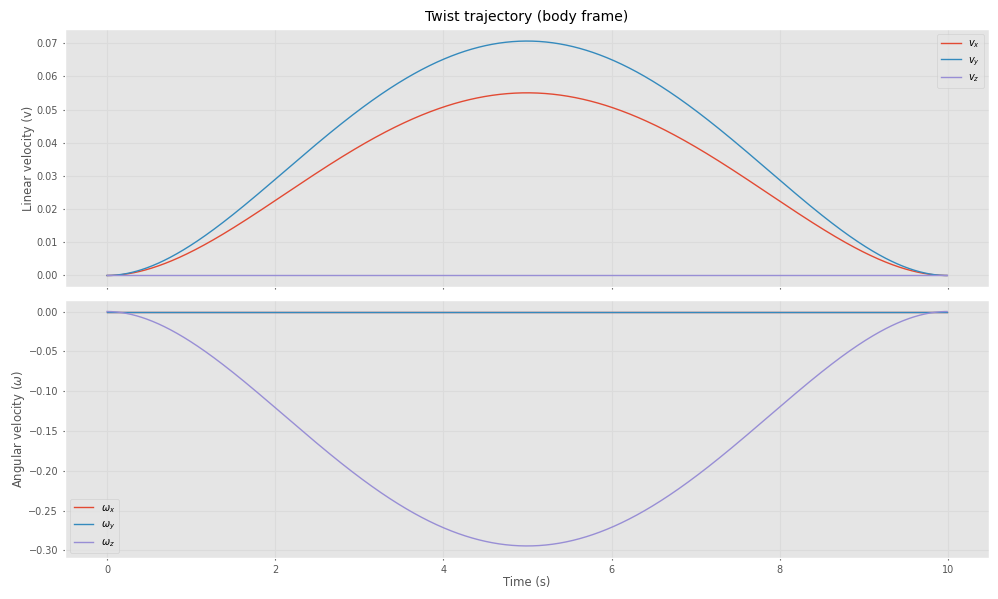

In [19]:
# Plot twist_b: (v, omega) order, shape (N, 6)
time_twist = np.arange(len(twist_trajectory)) * adapter.dt
labels = [r'$v_x$', r'$v_y$', r'$v_z$', r'$\omega_x$', r'$\omega_y$', r'$\omega_z$']
ylabels = ['Linear velocity (v)', 'Angular velocity ($\omega$)']

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
for i in range(3):
    axes[0].plot(time_twist, twist_trajectory[:, i], label=labels[i], linewidth=1)
    axes[1].plot(time_twist, twist_trajectory[:, i+3], label=labels[i+3], linewidth=1)

for ax, ylabel in zip(axes, ylabels):
    ax.set_ylabel(ylabel)
    ax.legend()
axes[1].set_xlabel('Time (s)')
axes[0].set_title('Twist trajectory (body frame)')
plt.tight_layout()
plt.show()

## Execute Manipulation - Real Robot

Execute the manipulation task on the real robot.


In [ ]:
# Execute manipulation on real robot
print("⚠️  Real robot will perform manipulation - ensure object is grasped and workspace is clear!")

# Generate twist trajectory for real robot manipulation
twist_trajectory = planner.generate_twist_trajectory(
    body_pose=grasp_pose,
    q=qs,
    s_axis=s_axes,
    theta=np.pi/2,  # 90 degree rotation
    h=0.0,          # no translation along screw axis
    theta_dot=0.5,  # angular velocity
    Tf=10.0,        # trajectory duration
    frequency=config.frequency,
    time_scaling='quintic',
    body_coordinate=True
)

result_manip_real = executor.follow_twist_trajectory(
    twist_trajectory=twist_trajectory,
    sim_robot=panda_sim,
    real_robot=panda_real,
    use_real_robot=True  # 🔴 REAL ROBOT EXECUTION
)

print(f"\nReal Robot Manipulation Results:")
print(f"  Steps: {result_manip_real.n_steps}")
print(f"  Execution time: {result_manip_real.execution_time:.2f}s")

# Save real manipulation data
result_manip_real.save("manipulation_real.npz")
print("Real manipulation data saved to 'manipulation_real.npz'")


INFO:pandaSim.control.robot_executor:Starting real robot velocity following: 1000 commands
INFO:panda:Stopping active controller (Integrated Velocity).
INFO:panda:Starting new controller (Integrated Velocity).


⚠️  Real robot will perform manipulation - ensure object is grasped and workspace is clear!


INFO:panda:Stopping active controller (Integrated Velocity).
INFO:pandaSim.control.robot_executor:Real robot velocity following completed



Real Robot Manipulation Results:
  Steps: 0
  Execution time: 0.00s
Real manipulation data saved to 'manipulation_real.npz'
